In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
acled = pd.read_csv("Asia-Pacific_2018-2024_Nov22.csv")
myanmar_raw = acled[acled.country == "Myanmar"]
myanmar21 = myanmar_raw[myanmar_raw.year >= 2021].copy()

In [3]:
# Remove 'non-violent' action
event_drop = ['Protests', 'Strategic developments', 'Riots']
myanmar21 = myanmar21[~myanmar21.event_type.isin(event_drop)].copy()

In [4]:
myanmar21 = myanmar21.copy()
myanmar21['event_date'] = pd.to_datetime(myanmar21['event_date'])
myanmar21['month'] = myanmar21['event_date'].dt.to_period('M')

In [5]:
events_total = myanmar21.groupby('month').size().reset_index()
events_total.rename(columns={0:'event_counts'}, inplace=True)
events_total['norm_events'] = events_total['event_counts'].to_numpy() / max(events_total['event_counts'])

In [6]:
# Group by month and event type, and count the number of events
monthly_event_counts = myanmar21.groupby(['month', 'event_type']).size().unstack(fill_value=0)

# Convert the index to strings
monthly_event_counts.index = monthly_event_counts.index.astype(str)

# Calculate the cumulative sum of the events for each month
cumulative_sums = monthly_event_counts.cumsum(axis=1)

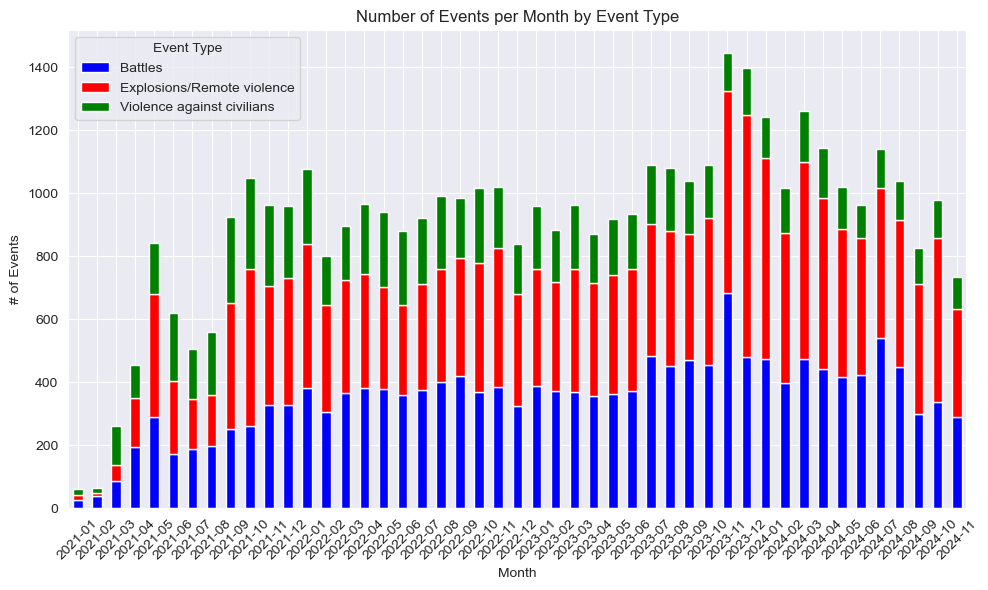

In [7]:
# Plot the stacked bar chart
monthly_event_counts.plot(kind='bar', stacked=True, color=['blue', 'red', 'green'], figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('# of Events')
plt.title('Number of Events per Month by Event Type')
plt.xticks(rotation=45)
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()

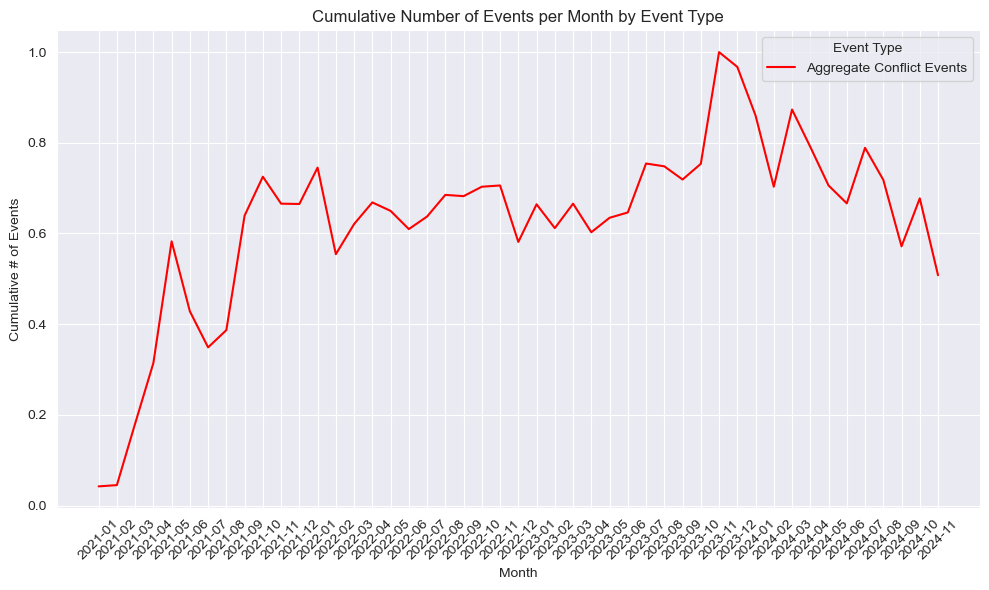

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(events_total['month'].astype(str), events_total['norm_events'], label="Aggregate Conflict Events", c='red')

plt.xlabel('Month')
plt.ylabel('Cumulative # of Events')
plt.title('Cumulative Number of Events per Month by Event Type')
plt.xticks(rotation=45)
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()

In [9]:
udcp = pd.read_csv('gedevents-2024-12-07.csv', index_col=False)
myanmar21 = udcp[udcp['year'] >= 2021]
columns_to_keep = ['id', 'year', 'best_est', 'date_start', 'date_end']

# Ensure only existing columns are selected
existing_columns = [col for col in columns_to_keep if col in myanmar21.columns]

# Create a new DataFrame with only the selected columns
bed = myanmar21[existing_columns]

In [10]:
bed = bed.copy()

bed['date_start'] = pd.to_datetime(bed['date_start'])
bed['month_year'] = bed['date_start'].dt.to_period('M')

monthly_sum = bed.groupby('month_year')['best_est'].sum().reset_index()

monthly_sum['norm_deaths'] = monthly_sum['best_est'].to_numpy() / max(monthly_sum['best_est'])

In [11]:
monthly_sum.head()

,month_year,best_est,norm_deaths
0,2021-02,23,0.044922
1,2021-03,314,0.613281
2,2021-04,141,0.275391
3,2021-05,258,0.503906
4,2021-06,91,0.177734


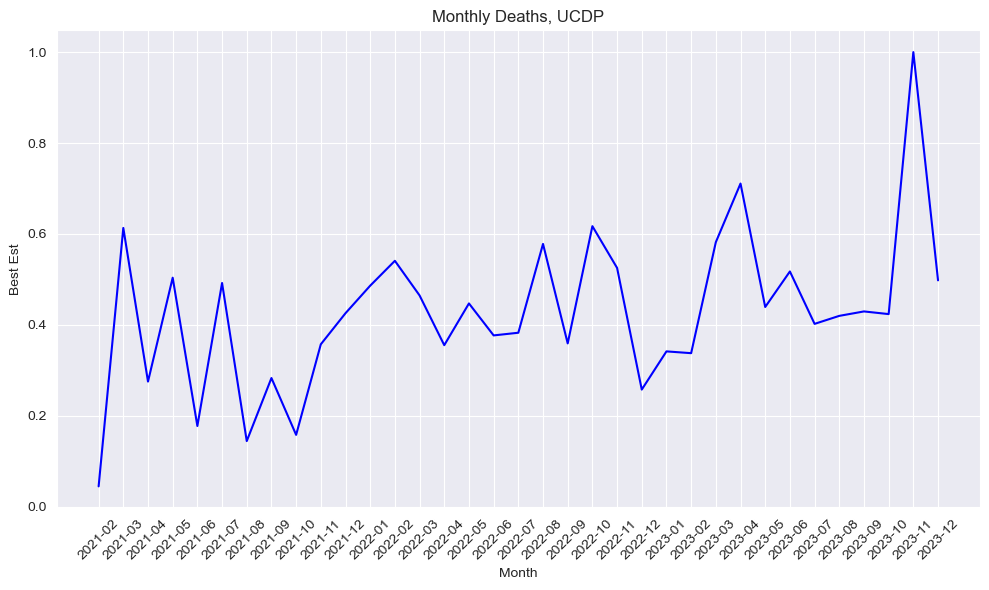

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_sum['month_year'].astype(str), monthly_sum['norm_deaths'], color='blue')
plt.xlabel('Month')
plt.ylabel('Best Est')
plt.title('Monthly Deaths, UCDP')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

In [13]:
cumulative_sums.columns

Index(['Battles', 'Explosions/Remote violence', 'Violence against civilians'], dtype='object', name='event_type')

In [14]:
events_total = events_total.sort_values(by='month').iloc[1:]
norm_deaths = monthly_sum.sort_values(by="month_year")

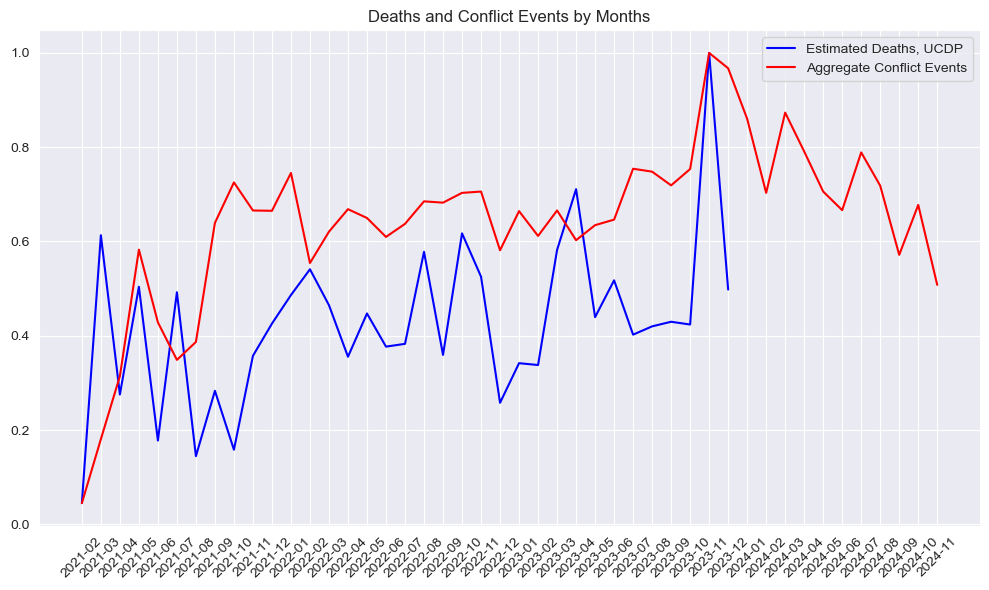

In [15]:
# Combined Graph

plt.figure(figsize=(10, 6))

plt.plot(norm_deaths['month_year'].astype(str), norm_deaths['norm_deaths'], color='blue', label='Estimated Deaths, UCDP', linestyle='-')
plt.plot(events_total['month'].astype(str), events_total['norm_events'], label="Aggregate Conflict Events", c='red')
plt.title("Deaths and Conflict Events by Months")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


In [16]:
# Merge the DataFrames on the time column
merged_df = pd.merge(norm_deaths, events_total, left_on='month_year', right_on='month', how='inner')

# Calculate the average
merged_df['average'] = (merged_df['norm_deaths'] + merged_df['norm_events']) / 2

merged_df_2 = merged_df[:min(len(events_total), len(norm_deaths))]  # Truncate to range where both data are available

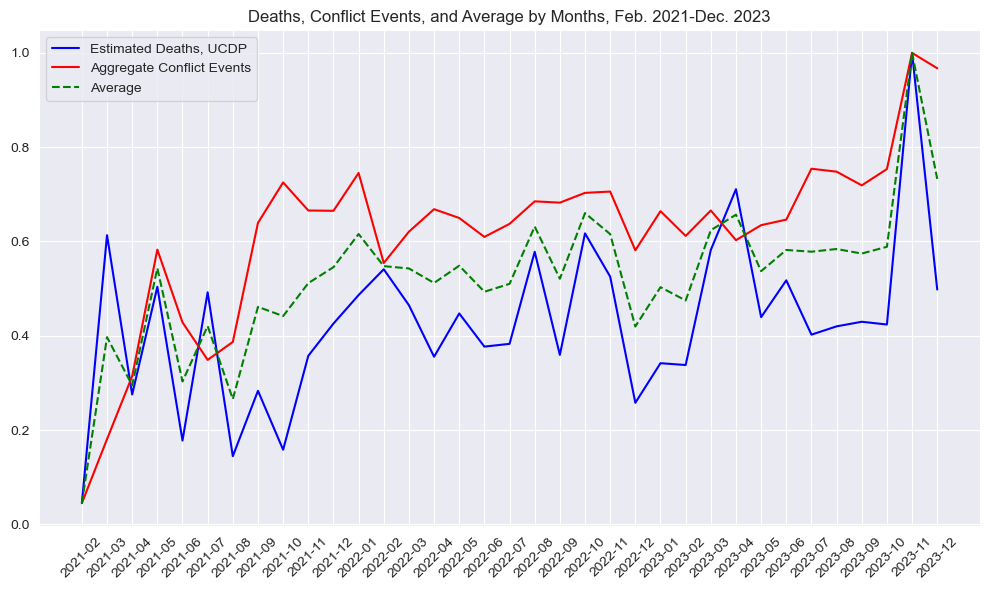

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(merged_df['month_year'].astype(str), merged_df['norm_deaths'], color='blue', label='Estimated Deaths, UCDP', linestyle='-')
plt.plot(merged_df['month'].astype(str), merged_df['norm_events'], label="Aggregate Conflict Events", c='red')
plt.plot(merged_df['month_year'].astype(str), merged_df['average'], color='green', label='Average', linestyle='--')

plt.title("Deaths, Conflict Events, and Average by Months, Feb. 2021-Dec. 2023")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

In [18]:
nds = norm_deaths['norm_deaths'].to_numpy()
print(f"mean = {np.mean(nds)} and variance = {np.var(nds)}")
print("We are missing " , len(events_total) - len(norm_deaths), " months of casualty data from UCDP")

S_0 = nds[-1]  # starting value
# norms = np.random.normal(np.mean(nds), np.std(nds), 11)

mean = 0.4277901785714286 and variance = 0.029874199069276144
We are missing  11  months of casualty data from UCDP


In [25]:
in_norms = [np.random.normal(np.mean(nds), np.std(nds), 11) for _ in range(20)]
norms = np.mean(in_norms, axis=0)
print(norms)

[0.42492024 0.40599792 0.46760204 0.38680603 0.44355389 0.44519022
 0.41637193 0.46497899 0.43163566 0.43412057 0.41768758]


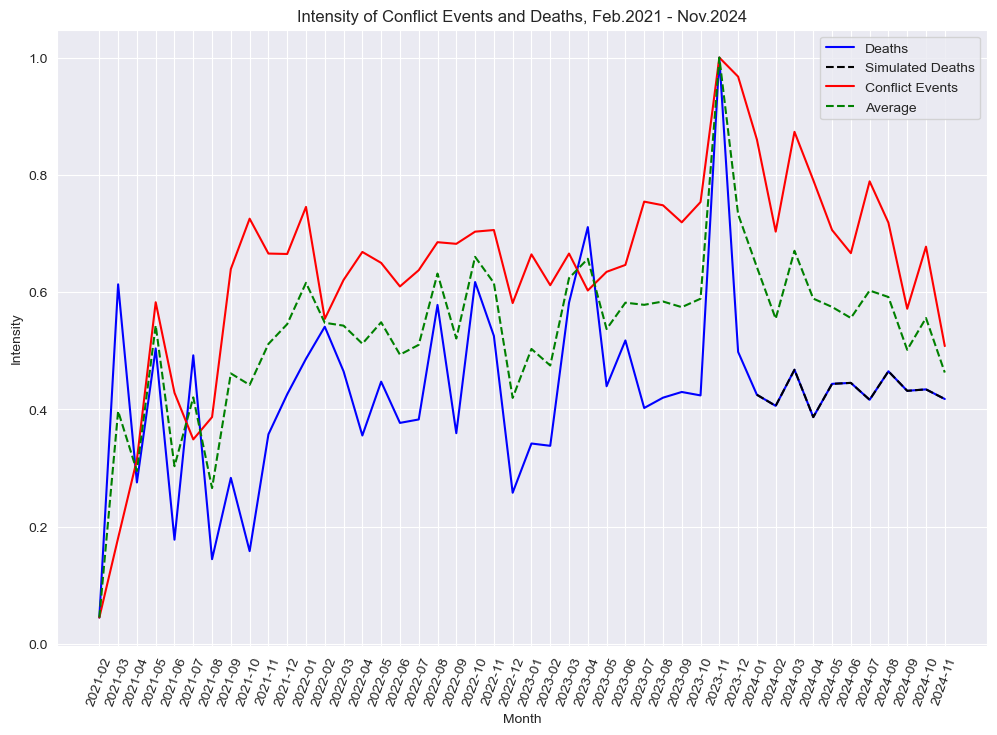

In [37]:
nds2 = np.append(nds, norms)
nes2 = events_total['norm_events'].to_numpy()
average = (nds2 + nes2) / 2

# average = pd.Series(average)
window_size = 2  # You can adjust the window size to control the smoothness
moving_average = pd.Series(average).rolling(window=window_size).mean()


plt.figure(figsize=(12, 8))
plt.plot(nds2, label='Deaths', linestyle='-', color='blue')  # Plot the entire series with a solid line
plt.plot(range(len(nds), len(nds2)), norms, label='Simulated Deaths', linestyle='--', color='black')
plt.plot(events_total['month'].astype(str), events_total['norm_events'], label="Conflict Events", c='red')
plt.plot(average, color='green', label='Average', linestyle='--')
# plt.plot(moving_average, color='orange', label='Moving Average', linestyle='--')

plt.legend()
plt.title("Intensity of Conflict Events and Deaths, Feb.2021 - Nov.2024")

plt.xlabel('Month')
plt.ylabel('Intensity')

plt.xticks(rotation=70)

plt.show()

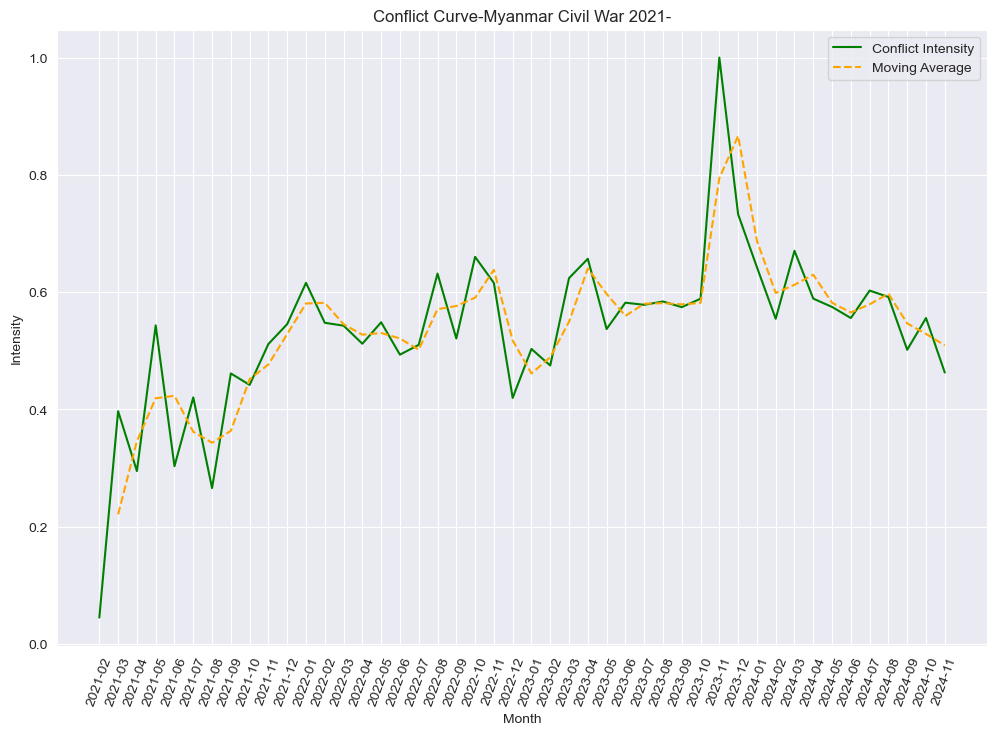

In [36]:
window_size = 2  # You can adjust the window size to control the smoothness
moving_average = pd.Series(average).rolling(window=window_size).mean()

plt.figure(figsize=(12, 8))
# plt.plot(nds2, label='Deaths', linestyle='-', color='blue')  # Plot the entire series with a solid line
# plt.plot(range(len(nds), len(nds2)), norms, label='Simulated Deaths', linestyle='--', color='white')
# plt.plot(events_total['month'].astype(str), events_total['norm_events'], label="Conflict Events", c='red')
plt.plot(events_total['month'].astype(str), average, color='green', label='Conflict Intensity', linestyle='-')
plt.plot(moving_average, color='orange', label='Moving Average', linestyle='--')

plt.legend()
plt.title("Conflict Curve-Myanmar Civil War 2021-")

plt.xlabel('Month')
plt.ylabel('Intensity')

plt.xticks(rotation=70)

plt.show()